<a href="https://colab.research.google.com/github/Vadiman728/A-model-based-on-the-BERT-architecture-for-censorship/blob/main/Bert_model_for_censorship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Задача на этот блокнот**: создать систему фильтров на основе BERT-подобной модели и русскоязычного датасета для классификаций и дообучить модель предсказывать класс.

---

# Импорт библиотек


In [ ]:
!pip install emoji==1.4.1
!pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.1/185.1 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-1.4.1-py3-none-any.whl size=186377 sha256=af7c6389e3ece4ead2477f82b685a2d3766a61c14ccd6a3feb99cbdf0a27c72c
  Stored in directory: /root/.cache/pip/wheels/35/27/d6/a425b9b845119a8e2f1fb85f405bc4ba2a836bd2805c3c8403
Successfully built emoji


In [ ]:
!pip install huggingface-hub

In [ ]:
# Библиотека линейной алгебры
import numpy as np

# Работа с датафреймом
import pandas as pd


# Обработка данных
import re, string
import emoji
import nltk
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


# Результаты BERT и roBert мы сравним с наивным байесовским классификатором
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# Токены и модели из библиотеки transformers
import torch
from transformers import AutoTokenizer, AutoModel
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

# Keras
import tensorflow as tf
from tensorflow import keras

# Метрики
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

# Для воспроизводимости результатов
seed=42

# Настройка стилей для графиков
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.despine()
plt.style.use("fivethirtyeight")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

# Отключим мешаюшие предупреждения
import warnings
warnings.filterwarnings("ignore")

<Figure size 640x480 with 0 Axes>

In [ ]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(12,12))
    labels = ['offline_crime', 'online_crime', 'drugs', 'gambling', 'pornography', 'prostitution', 'slavery', 'suicide', 'terrorism', 'weapons', 'body_shaming', 'health_shaming', 'politics', 'racism', 'religion', 'sexual_minorities', 'sexism', 'social_injustice']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":8})
    plt.title(title, fontsize=5)
    ax.xaxis.set_ticklabels(labels, fontsize=5)
    ax.yaxis.set_ticklabels(labels, fontsize=5)
    ax.set_ylabel('Тест', fontsize=5)
    ax.set_xlabel('Предсказание', fontsize=5)
    plt.show()

# Работа с датасетом

## Импорт датасета

Для работы берем датасет, который оценивает, к какой деликатной теме относится тот или иной комментарий (котики, оранжевый йутуб, азарт и прочее).


> Небольшая ремарка: Автор сего блокнота не стремится кого-либо обидеть или задеть чьи-то чувства. Это просто датасет, а я просто ML-щик. И извиняюсь за нецензурщину и некоторую откровенность в датасете.





In [ ]:
df = pd.read_csv("hf://datasets/NiGuLa/Russian_Sensitive_Topics/sensitive_topics.csv")

In [ ]:
df.head()

,text,offline_crime,online_crime,drugs,gambling,pornography,prostitution,slavery,suicide,terrorism,weapons,body_shaming,health_shaming,politics,racism,religion,sexual_minorities,sexism,social_injustice
0,РРРРРРЯЯЯЯЯЯЯ РУССКИЕ ВАНЬКИ НИКОМУ НЕ НУЖНЫ!!...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,"По моему, быдло тот кто осуждает чужие предпоч...",0.0,0.0,0.0,0.0,1.0,0.80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,Бабы это вообще безхуйные сиськастые ссущие си...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,изнасиловалиа говорила что девственницаЯ так д...,0.0,0.0,0.0,0.0,1.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,"и что ? не сосут только уебищные тни, видосов ...",0.0,0.0,0.0,0.0,1.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33303 entries, 0 to 33302
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   text               33303 non-null  object 
 1   offline_crime      33303 non-null  float64
 2   online_crime       33303 non-null  float64
 3   drugs              33303 non-null  float64
 4   gambling           33303 non-null  float64
 5   pornography        33303 non-null  float64
 6   prostitution       33303 non-null  float64
 7   slavery            33303 non-null  float64
 8   suicide            33303 non-null  float64
 9   terrorism          33303 non-null  float64
 10  weapons            33303 non-null  float64
 11  body_shaming       33303 non-null  float64
 12  health_shaming     33303 non-null  float64
 13  politics           33303 non-null  float64
 14  racism             33303 non-null  float64
 15  religion           33303 non-null  float64
 16  sexual_minorities  333

In [ ]:
df = df.dropna()

Специфичный датасет, ну а почему бы и нет? Но необычность датасета в том, что метка это название столбцов, а относится или нет к заданной тематике показано индексом от 0 до 1.0, что подразумевает доли в процентах. Извлечем метки отдельно в словарь.

## Извлечение меток

In [ ]:
# Извлечение названий столбцов
column_names = df.columns.to_list()
# Вывод названий столбцов
print(column_names)


['text', 'offline_crime', 'online_crime', 'drugs', 'gambling', 'pornography', 'prostitution', 'slavery', 'suicide', 'terrorism', 'weapons', 'body_shaming', 'health_shaming', 'politics', 'racism', 'religion', 'sexual_minorities', 'sexism', 'social_injustice']


In [ ]:
numbers = range(0, len(column_names[1:]))

labels_dict = dict(zip(numbers, column_names[1:]))
print(labels_dict)

{0: 'offline_crime', 1: 'online_crime', 2: 'drugs', 3: 'gambling', 4: 'pornography', 5: 'prostitution', 6: 'slavery', 7: 'suicide', 8: 'terrorism', 9: 'weapons', 10: 'body_shaming', 11: 'health_shaming', 12: 'politics', 13: 'racism', 14: 'religion', 15: 'sexual_minorities', 16: 'sexism', 17: 'social_injustice'}


# Токенизация

За токенизатор у нас отвечает ruBERT-tiny v2. Свыше 83 000 токенов, увеличена максимальная длина обрабатываемых последовательностей (2048 вместо 512, но они то нам особо не нужны). Модель так же обучена на этом датасете. При обучении выборок модель поменяется, поэтому, как говорится, следите за пальцами

In [ ]:
# pip install transformers sentencepiece

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
# model.cuda()  # uncomment it if you have a GPU

def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

print(embed_bert_cls('привет мир', model, tokenizer).shape)
# (312,)


tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

(312,)


Слишком длинные последовательности означают, что там или очень длинная фраза (которой можно принебречь) или много непонятных слов. В любом случае длинные последовательности следует удалить

In [ ]:
token_lens = []

for txt in df['text'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)

In [ ]:
print(f"Максимальная длина токенизированной последовательности: {max_len}")

Максимальная длина токенизированной последовательности: 164


Смотрим, что это за последовательности

In [ ]:
token_lens = []

for i,txt in enumerate(df['text'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 0, TEXT: РРРРРРЯЯЯЯЯЯЯ РУССКИЕ ВАНЬКИ НИКОМУ НЕ НУЖНЫ!!NUMBER!!NUMBER САМЫЕ УРОДЛИВЫЕ МУЖИКИ НА СВЕТЕ!!!NUMBER! МНЕ ТАК НА САЙТЕ БЬЮТИФУЛПИПЛ СКОЗАЛИ!!!NUMBER
INDEX: 872, TEXT: L NUMBERк в мес. дохода пидорашка. ЕБАНЫЙ ОЧКАРИК НА КНОПКИ ДАВИТ, к ПОЛУЧАЕТ ДА ЧЕМ ОН ЛУЧШЕ МЕНЯ!NUMBER ОТНЯТЬ ПОДЕЛИТЬ!NUMBER Этот министр вполне заслужено получает NUMBERкк в месяц, ты лучше с себя начни, левак проклятый.
INDEX: 953, TEXT: КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ НЕТ ОБСУЖДЕНИЯ ПОЛИТИКИ. СВОБОДНОЕ ОБЩЕНИЕ ЭТО В . ЭТО ТОЖЕ САМОЕ ЕСЛИ Я НА ДОСКЕ О ПОЛИТИКЕ СОЗДАМ ТРЕД О ТОМ КАК ПЛОХО БЕЗ ТЯНОЧКИ. ТАК ЧТО УЕБЫВАЙТЕ В Б ИЛИ НВР СО СВОИМ ЧАТИКОМ ПРЕСТАРЕЛЫХ ГОМОСЕКОВ!
INDEX: 1149, TEXT: Ебан вылез из спячки и обдристался. Три чипа, сука, даунина тупая, высрыш обоссаной шлюхи, ТРИ НОВЫХ ЧИПА у амуды - два представленных говна и вега с NUMBERгб хбмNUMBER. И откуда твой атрофированный мозг высрал с NUMBERгб гддрNUMBERхписькосос?
INDEX: 1159, TEXT: РРЯЯЯЯ, КУБАНОИДЫ НЕ РУССКИЕ, НАХУЙ ВЫ НУ

Добавляем в датасет колонку с длинами каждой последовательности

In [ ]:
df['token_lens'] = token_lens

In [ ]:
df = df.sort_values(by='token_lens', ascending=False)
df.head(20)

,text,offline_crime,online_crime,drugs,gambling,pornography,prostitution,slavery,suicide,terrorism,weapons,body_shaming,health_shaming,politics,racism,religion,sexual_minorities,sexism,social_injustice,token_lens
23140,----------------------------------------------...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,164
2087,АХАХХААХХАХАХАХАХАХАХАЭТО ПРОСТО БЛЯДЬ НОВЫЙ У...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.00,0.0,0.0,1.0,0.0,0.0,157
14285,----------------------------------------------...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,144
29366,РАЗ ИХ ДЕРЖАТ ЗНАЧИТ ИМИ ПОЛЬЗУЮТСЯ ДЛЯ КАКИХ ...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,143
14396,----------------------------------------------...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,142
28590,"Где винтовка Мосина, Винчестер,Колть,ППШ-NUMBE...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,140
2929,ОПОЗДАЛ НА РАБОТУ НА NUMBER ЧАСОВ ВОПРОС ГДЕ Т...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,138
953,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,136
29854,У МЕНЯ БЫЛ НОМЕР NUMBER ПЫТАЛИСЬ РАЗВЕСТИ НА N...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,136
21578,БЫЛ ЛИ ИИСУС СЫНОМ БОГА ...?ДА КОНЕЧНО БЫЛ...И...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,136


Мы, пожалуй, скинем все 20 последовательностей, чтобы приблизать максимальную длину к 100

In [ ]:
df = df.iloc[20:]
df.head()

,text,offline_crime,online_crime,drugs,gambling,pornography,prostitution,slavery,suicide,terrorism,weapons,body_shaming,health_shaming,politics,racism,religion,sexual_minorities,sexism,social_injustice,token_lens
22917,"NUMBER глава Евангелия Иоанна говорит, что как...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,109
28312,УГРОЗА ИДЕТ НЕ ОТ ИГИЛ А ТАКИХ КАК ВЫ УВАЖАЕМЫ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,108
24906,"NUMBER. Ахимелех НЕ БЫЛ первосвященником, т.к....",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,107
9793,Ads NUMBER дизайнаВАКУУМНЫЙ ОЧИСТИТЕЛЬ - руб...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107
26845,Мой отец попал в # NUMBER в больницу на Автоза...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107


In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

Собираем метки

In [ ]:
labels = df[['offline_crime', 'online_crime', 'drugs', 'gambling', 'pornography', 'prostitution', 'slavery', 'suicide', 'terrorism', 'weapons', 'body_shaming', 'health_shaming', 'politics', 'racism', 'religion', 'sexual_minorities', 'sexism', 'social_injustice']].values

In [ ]:
print(labels.shape)

(33283, 18)


Переводим текст в массив

In [ ]:
X = df['text'].values

Теперь у нас чуть очищенный датасет. Так же мы заранее сделали labels и превратили их в массив

In [ ]:
type(labels)

numpy.ndarray

Потому теперь можем составить наборы данных 8-1-1 тренировочные-тестовые-валидационные

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, labels, test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 42)

In [ ]:
y_val.shape

(3329, 18)

# Tokenise and embedings

Далее будет токенизация последовательностей. В токенизаторе есть функция возвращения маски внимания. Это чудо поможет отследить точность

In [ ]:
def tokenize(data, max_len=128):
    input_ids = []
    attention_masks = []
    # Преобразуем данные из numpy.ndarray в список строк
    data_list = data.tolist() if isinstance(data, np.ndarray) else data

    for text in data_list:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            truncation=True  # Позволяет обрезать текст при превышении max_len
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids), np.array(attention_masks)

Получаем выборки

In [ ]:
train_input_ids, train_attention_masks = tokenize(X_train)
val_input_ids, val_attention_masks = tokenize(x_val)
test_input_ids, test_attention_masks = tokenize(x_test)

# Обучение модели

Как я и говорил- здесь меняется модель. Обоснование в том, что токенизатор(который импортировали ранее) лучше работает именно на AutoModel, а генерация лучше проходит именно на BERT модели. Но не переживайте, предобучена она на том же reBERT-tiny 2. Приставка TF в импортируемой модели говорит о том, что она работает с тензорами (наш случай). Импортируем модель, также предобученную на ruBERT-е.

In [ ]:
from sentence_transformers import SentenceTransformer
model = TFBertModel.from_pretrained('cointegrated/rubert-tiny2')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'bert.embeddings.position_ids', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already u

Собираем модель. Оптимизатор Адам, и так как у нас мультиклассовая классификация, то за функцию потери сегодня отвечает категориальная кросс энтропия

In [ ]:
def create_model(bert_model, max_len=128):
    # Параметры обучения
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')

    # Получаем выходы BERT
    outputs = bert_model([input_ids, attention_masks])
    embeddings = outputs[0]  # Получаем все выходы (версии для токенов)

    # Выбираем CLS токен
    cls_output = embeddings[:, 0, :]  # Берем выход CLS токена

    outputs = tf.keras.layers.Dense(18, activation="softmax")(cls_output) # 18 = количеству тем в labels. можно было бы заменить на labels.shape[1]
    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=outputs)
    model.compile(optimizer=opt, loss=loss, metrics=[accuracy])

    return model

In [ ]:
model = create_model(model)

# Обучение

Специально наши данные не были обработаны (не удалены слишком длинные последовательности (максимальная длина 100+, но на ресурсы в нашем случае влияния не будет), не убраны знаки препинания и пр), поэтому проведем эксперимент- попробуем скормить модели то, что есть и посмотрим, как она будет справляться.

**Еще ремарка.** Автор не поддерживает такой подход к обучению. Данные **должны быть** нормализованы, почищены, проведены все необходимые операции. Здесь же эксперимент, для того, чтобы показать мощь BERT архитектуры

In [ ]:
history_bert = model.fit([train_input_ids, train_attention_masks], y_train, validation_data=([val_input_ids, val_attention_masks], y_val), epochs=10, batch_size=32)

Epoch 1/10


833/833 [==============================] - 70s 74ms/step - loss: 1.9330 - categorical_accuracy: 0.4491 - val_loss: 1.1815 - val_categorical_accuracy: 0.6600
Epoch 2/10
833/833 [==============================] - 64s 77ms/step - loss: 1.1244 - categorical_accuracy: 0.6818 - val_loss: 1.0408 - val_categorical_accuracy: 0.7020
Epoch 3/10
833/833 [==============================] - 61s 73ms/step - loss: 1.0187 - categorical_accuracy: 0.7095 - val_loss: 1.0149 - val_categorical_accuracy: 0.7143
Epoch 4/10
833/833 [==============================] - 61s 73ms/step - loss: 0.9627 - categorical_accuracy: 0.7263 - val_loss: 0.9968 - val_categorical_accuracy: 0.7330
Epoch 5/10
833/833 [==============================] - 61s 73ms/step - loss: 0.9121 - categorical_accuracy: 0.7390 - val_loss: 0.9892 - val_categorical_accuracy: 0.7342
Epoch 6/10
833/833 [==============================] - 68s 82ms/step - loss: 0.8796 - categorical_accuracy: 0.7485 - val_loss: 0.9856 - val_categorical_accuracy: 0.7408
Epo

In [ ]:
result_bert = model.predict([test_input_ids, test_attention_masks])

104/104 [==============================] - 2s 17ms/step


Получаем предсказания

In [ ]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

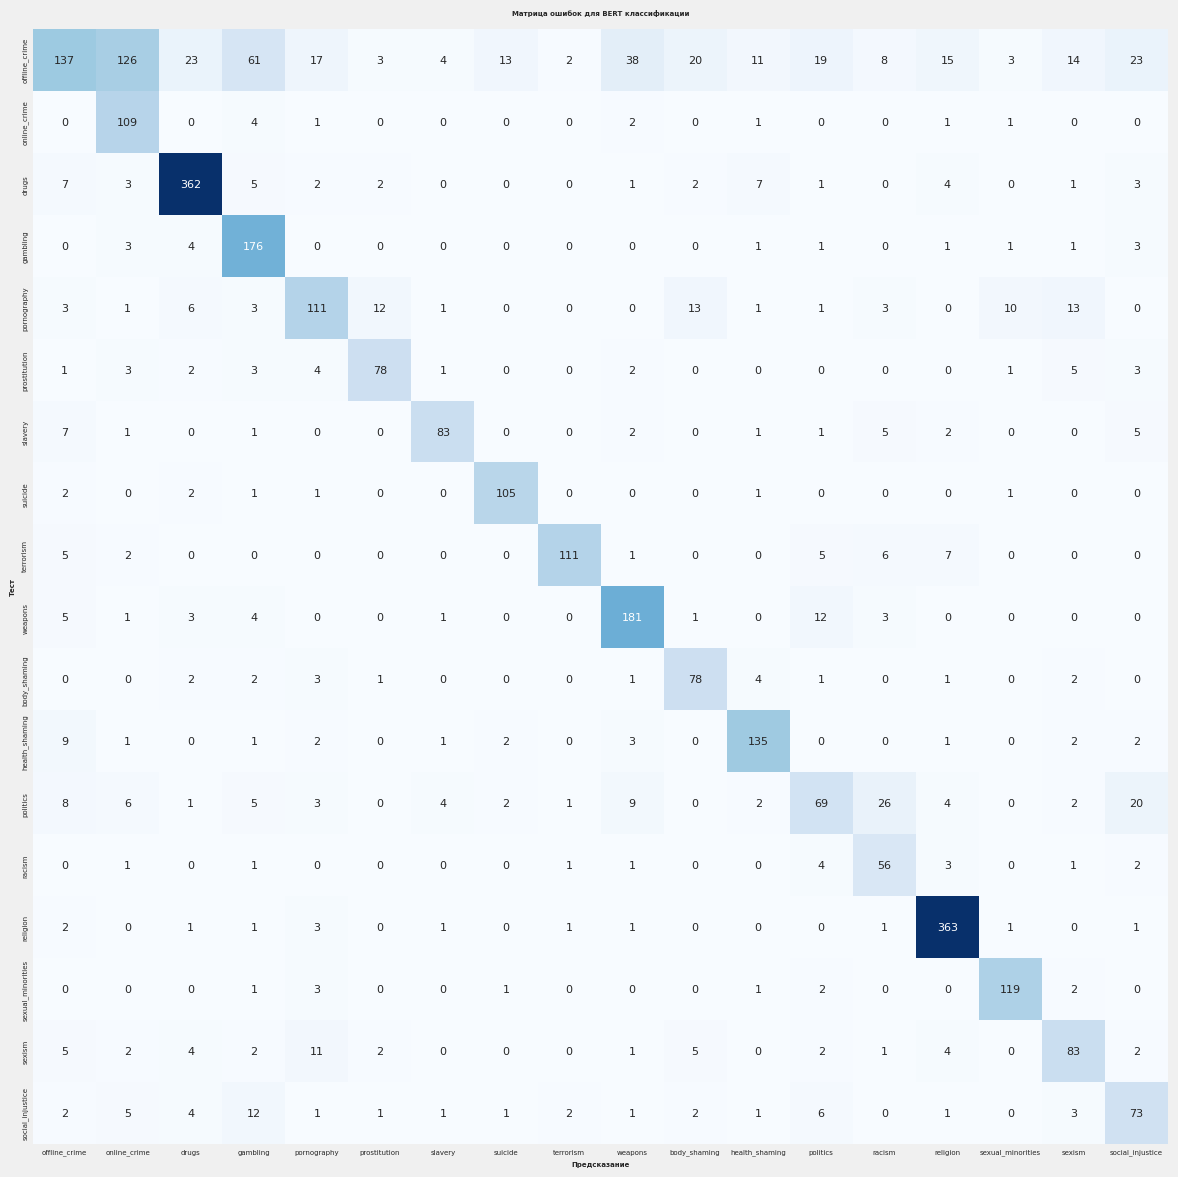

In [ ]:
conf_matrix(y_test.argmax(1), y_pred_bert.argmax(1),'Матрица ошибок для BERT классификации')

Хороший результат для неочищенных данных. Плюс имеем в виду, что у нас мультиклассовая классификация, поэтому матрица ошибок (матрица отклонений, confusion matrix (подставьте своё)) не будет сбалансированной, но основная парадигма, что чем контрастнее диагональ, тем лучше, соблюдена.

# Примеры

Для начала создадим функцию, чтобы просто не утонуть в строчках кода. Первая `predict` отвечает за вывод предсказаний модели в красивой обертке, а `test` красиво обрабатывает данные с тестовой выборки

In [ ]:


def predict(input_text):
  inputs = tokenizer.encode_plus(input_text,
                                add_special_tokens=True,  # добавляет [CLS] и [SEP]
                                max_length=128,  # максимальная длина (можете изменить)
                                padding='max_length',  # добавляет заполнение до максимальной длины
                                truncation=True,  # усечёт текст, если он длиннее max_length
                                return_tensors='pt')  # возвращает рукотворные тензоры PyTorch

  # Получаем необходимые данные
  input_id = inputs['input_ids']  # идентификаторы токенов
  attention_mask = inputs['attention_mask']  # маска внимания

  input_id = np.array(input_id)
  attention_mask = np.array(attention_mask)

  # Получаем предсказание
  result = model.predict([input_id, attention_mask])

  result = np.round(result, 2)

  result_array_flat = np.array(result.flatten())
  # Формируем вывод
  output = []
  for i, probability in enumerate(result_array_flat):

      if probability != 0:  # Выводим только метки с ненулевыми вероятностями
          output.append(f"{labels_dict[i]} с вероятностью {probability:.2f}")

  # Объединяем все строки в один вывод
  final_output = "Это " + " и ".join(output)
  print(final_output)

def test(test):
    # Преобразуем массив в одномерный
    result_array_flat = np.array(test.flatten())
    # Формируем вывод
    output = []
    for i, probability in enumerate(result_array_flat):

        if probability != 0:  # Выводим только метки с ненулевыми вероятностями
            output.append(f"{labels_dict[i]} с вероятностью {probability}")

    # Объединяем все строки в один вывод
    final_output = "Это " + " и ".join(output)
    print(final_output)

In [ ]:
print(x_test[0])
print(predict(x_test[0]))
print(test(y_test[0]))

Похоже чел никогда проститутку не видел...в основном они предпочитают старше NUMBER...а NUMBER летние эт мечта проститутки
1/1 [==============================] - 0s 37ms/step
Это pornography с вероятностью 0.01 и prostitution с вероятностью 0.99 и sexism с вероятностью 0.01
None
Это prostitution с вероятностью 1.0
None


И еще 5 примеров не помешают

In [ ]:
import random

random_indices = random.sample(range(1, len(x_test) + 1), 5)

for i in random_indices:
  print()
  print(x_test[i])
  print(predict(x_test[i]))
  print(test(y_test[i]))
  print()


сердечный приступ от ожирения, это личное дело каждого.
1/1 [==============================] - 0s 57ms/step
Это suicide с вероятностью 0.02 и body_shaming с вероятностью 0.05 и health_shaming с вероятностью 0.93
None
Это body_shaming с вероятностью 1.0
None


NUMBER. Ударопрочность, всепогодность, водонепроницаемостьу обоих типов прицелов примерно на одном уровне. Абсолютно достаточном. Ситуация аналогична параллаксу.
1/1 [==============================] - 0s 72ms/step
Это online_crime с вероятностью 0.02 и suicide с вероятностью 0.01 и weapons с вероятностью 0.89 и body_shaming с вероятностью 0.01 и health_shaming с вероятностью 0.01 и politics с вероятностью 0.04 и racism с вероятностью 0.01
None
Это weapons с вероятностью 1.0
None


То есть по мнению коммуниста Рудого в России есть либералы и охранители И ВСЁ Это на столько тупо, что аж хорошо
1/1 [==============================] - 0s 59ms/step
Это politics с вероятностью 0.99
None
Это politics с вероятностью 1.0
None


Хм, надо оп

Результаты потрясающие, мы переизобрели систему ранга комментариев, которые скрывает фильтры. На практике компаниями используются огромные датасеты и большие вычислительные мощности, но и наша работа на ограниченных мощностях и небольшом датасете показала хороший результат.